In [24]:
# Import packages
import xarray as xr
import numpy as np
import pandas as pd
import packaging
import matplotlib.pyplot as plt
import netCDF4
import math
import datetime

# Suppress warnings from RuntimeWarning: divide by zero encountered in log result = getattr(ufunc, method)(*inputs, **kwargs)
# Instances of this error have been recognized and dealt with. It will still occur, but then the results will be fixed retroactively
# This will occur when there is an extremely intense period of precipitation in the historical record and CDF value is 1.00
# You can find instances of this by looking at the .csv output and finding spots where past_pr and future_pr are == inf
np.seterr(divide='ignore', invalid='ignore')

# Define functions
def read_netcdf4(filename):
    '''Read in data from netcdf4'''
    # read in netcdf4 data to xarray
    storms_data = xr.open_dataset(filename)
    
    return storms_data

def tidy_CONUS_netcdf4(storms_data, city):
    '''Convert to dataframe, assign headers, set data types, perform unit conversions if necessary'''
    
    # tidy data
    storms_data = storms_data['RAINRATE'].sel(location = city).to_dataframe()
    
    # make datetime its own column, not the index
    storms_data['datetime'] = storms_data.index
    storms_data = storms_data.reset_index(drop = True)
    storms_data['datetime'] = pd.to_datetime(storms_data['datetime'])
    storms_data = storms_data.rename(columns = {"RAINRATE": "pr"})
    
    # reorder columns for clarity
    storms_data = storms_data.iloc[:,[0, 2, 1]]
    
    # perform unit conversions if necessary
    # default units for CONUS404 netcdf4 are mm to 0.1 mm accuracy
    
    return storms_data

def tidy_AORC_netcdf4(storms_data, city):
    '''Convert to dataframe, assign headers, set datatypes, perform unit conversions if necessary'''
    
    # tidy data
    storms_data = storms_data.sel(location = city).to_dataframe()

    # storms_data = storms_data['RAINRATE'].sel(location = city).to_dataframe()
    # rain = big_AORC['RAINRATE'].sel(location='Arlington')

    
    # make datetime its own column, not the index
    storms_data['datetime'] = storms_data.index
    storms_data = storms_data.reset_index(drop = True)
    storms_data['datetime'] = pd.to_datetime(storms_data['datetime'])
    storms_data = storms_data.rename(columns = {"RAINRATE": "pr"})
    
    # reorder columns for clarity
    storms_data = storms_data.iloc[:,[3, 4, 0]]
    
    # perform unit conversions if necessary
    # default units for AORC-CONUS netcdf4 precipitation are kg/m^2 ie: mm depth, so not conversions necessary
       
    
    return storms_data

def read_csv(city):
    '''Read in data from csv, assign headers, set datatypes, perform unit conversions if necessary, and find time step for
       the dataset in minutes.'''
    # read data from csv
    storms_obs = pd.read_csv(f"files/NOAA_15_min/{city}.csv", skiprows = 0, parse_dates = ['DATE'])

    # drop unneccessary and rename cols
    storms_obs = storms_obs.loc[:, ['DATE', 'QPCP']]
    storms_obs = storms_obs.rename(columns = {'DATE' : 'datetime', 'QPCP' : 'pr'})
    
    # QC data - remove NA and NULL values
    # print(storms_obs.loc[:, 'pr'].min(), storms_obs.loc[:, 'pr'].max())
    # remove any negative vals
    storms_obs.loc[storms_obs.pr < 0, 'pr'] = 0
    # remove any exceptionally large vals - > 500 chosen arbitrarily
    storms_obs.loc[storms_obs.pr > 500, 'pr'] = 0
    # print(storms_obs.loc[:, 'pr'].min(), storms_obs.loc[:, 'pr'].max())
    
    return storms_obs

def find_timestep(storms_data):
    '''Find time step of dataset in minutes by subtracting two datetimes'''
    # determine time step by subtracting one datetime from another
    TS = storms_data.iloc[1, 1] - storms_data.iloc[0, 1]
    
    # convert timedelta type to int type in minutes
    TS = TS.total_seconds() / 60
    return TS

def project_by_intensity(storms_modeled_past, storms_modeled_future, storms_obs, TS, subset):
    '''This is the meat of the process. It accepts model and historical data, finds Gumbel shape factors from each dataset, uses them to find
    the CDF value that corresponds with each precipitation intensity, calculates delta factors, and returns a time series of historical
    precipitation that has been projected into the future.'''
    
    # !! resampling actually doesn't work with this data because its TS are non-adjacent temporally
    # !! for now, get hourly values by multiplying 15-min by 4
    # ==========================================================================================================================
    # # resample observed dataset to find hourly sums. This aligns the volumes from the hourly model data and the observed data
    resample = storms_obs.resample('60min', on = 'datetime').sum()
    # adjust index to include same number of entries as storms_obs
    resample = resample.loc[resample.index.repeat(60 / TS)].reset_index()
    # add resampled data to storms_obs
    storms_obs['pr_hourly'] = resample.pr
    # ==========================================================================================================================
    
    
    # remove all dry times from datasets - this way only rainy periods are used to characterize the precipitation
    storms_modeled_past_no_0 = storms_modeled_past[storms_modeled_past['pr'] != 0]
    storms_modeled_future_no_0 = storms_modeled_future[storms_modeled_future['pr'] != 0]
    storms_obs_no_0 = storms_obs[storms_obs['pr_hourly'] != 0]    
    
    # calculate statistics for each storm duration based on full rolling input of ~past~ data and find shape factors
    past_mean_pr = storms_modeled_past_no_0['pr'].mean()
    past_std_pr  = storms_modeled_past_no_0['pr'].std()
    euler_mascheroni_constant = 0.577215
    past_beta = past_std_pr * math.sqrt(6) / math.pi
    past_mu = past_mean_pr - past_beta * euler_mascheroni_constant

    # calculate statistics for each storm duration based on full rolling input of ~future~ data and find shape factors
    future_mean_pr = storms_modeled_future_no_0['pr'].mean()
    future_std_pr  = storms_modeled_future_no_0['pr'].std()
    future_beta = future_std_pr * math.sqrt(6) / math.pi
    future_mu = future_mean_pr - future_beta * euler_mascheroni_constant
        
    # calculate statistics for each storm duration based on full rolling input of ~observed~ data and find shape factors
    obs_mean_pr = storms_obs_no_0['pr_hourly'].mean()
    obs_std_pr  = storms_obs_no_0['pr_hourly'].std()
    obs_beta = obs_std_pr * math.sqrt(6) / math.pi
    obs_mu = obs_mean_pr - obs_beta * euler_mascheroni_constant
    
    
    # find the associated CDF value for each precipitation time step, solve for delta factors, and project the observed values into the future
    subset = subset.copy()
    subset.loc[:, 'obs_CDF']      = np.exp(-1 * np.exp(-1 * (subset.loc[:, 'pr'] - obs_mu) / obs_beta))    
    subset.loc[:, 'past_CDF']     = np.exp(-1 * np.exp(-1 * (subset.loc[:, 'pr'] - past_mu) / past_beta))
    subset.loc[:, 'future_CDF']   = np.exp(-1 * np.exp(-1 * (subset.loc[:, 'pr'] - future_mu) / future_beta))
    subset.loc[:, 'past_pr']      = -1 * past_beta *   (np.log(-1 * np.log(subset.loc[:, 'obs_CDF']))) + past_mu
    subset.loc[:, 'future_pr']    = -1 * future_beta * (np.log(-1 * np.log(subset.loc[:, 'obs_CDF']))) + future_mu
    subset.loc[:, 'delta']        = subset.loc[:, 'future_pr'] / subset.loc[:, 'past_pr']    
    subset.loc[:, 'projected_pr'] = subset.loc[:, 'delta'] * subset.loc[:, 'pr']


    
    # Add switch to fix edge case where model CDFs are negative for the smallest precipitation values
    # this is caused by the model under predicting precipitation for the study year
    subset.loc[subset.past_pr < 0, 'delta'] = 1
    subset.loc[subset.future_pr < 0, 'delta'] = 1
    subset.loc[subset.delta == 1, 'projected_pr'] = subset.pr

    # If obs_CDF is = 1.00 then past_pr and future_pr will be inf. Add switch to prevent this by using the same delta as the next largest storm
    subset.loc[subset.obs_CDF == 1, 'delta'] = subset.delta.max()
    subset.loc[subset.obs_CDF == 1, 'projected_pr'] = subset.pr * subset.delta
    
    
    return subset

In [29]:
# Import requisite data =================================================================================
# Read netCDF4 data - climate model results for CONUS 404 historical and pseudo global warming runs
CONUS_modeled_past   = read_netcdf4('files/CONUS/CONUS404-Historical-50largestcities.nc')
CONUS_modeled_future = read_netcdf4('files/CONUS/CONUS404-PGW-50largestcities.nc')

CONUS_city_list = CONUS_modeled_past['location'].values.tolist()

# Read netCDF4 data - climate model results for AORC-CONUS historical runs
AORC_historical = read_netcdf4('files/AORC/AORC-1km-data-allyears.nc')

# Set plot parameters ===================================================================================
# Establish colors to be used for plots
color0 = ('#1b9e77') # Past modeled
color1 = ('#d95f02') # Future modeled
color2 = ('#7570b3') # Past observed
color3 = ('#E7298A') # Future projected

# Set font for plots
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 16})

# Set figure size
plt.figure(figsize=(14, 5.6))

# Here's a place where I can reproduce results for one city only
# CONUS_city_list = ['Minneapolis']

print("Working...\nFinished:")

# Run the tool to project precipitation time series =====================================================
# Establish a loop that will produce results for each of the 50 cities
for city in CONUS_city_list:
    print(city) # do this to see which cities have divide by zero errors
    
    # isolate data for that city from big NETCDF4 files
    storms_modeled_past =   tidy_CONUS_netcdf4(CONUS_modeled_past, city)
    storms_modeled_future = tidy_CONUS_netcdf4(CONUS_modeled_future, city)

    # read historical data for that city from csv 
    storms_obs = tidy_AORC_netcdf4(AORC_historical, city)

    # check time step of AORC data (CONUS and AORC TS are known as 1 hr)
    TS = find_timestep(storms_obs)

    year = 2000
    storms_obs_year = storms_obs[storms_obs['datetime'].dt.year == year]

    # Project time series and save results
    projected_by_intensity = project_by_intensity(storms_modeled_past, storms_modeled_future, storms_obs, TS, storms_obs_year)
    projected_by_intensity.to_csv(f'files/output/dataframes/{city}.csv', index = False)
    
    
    # Plot CDFs ========================================================================================
    # Select data to be plotted    
    x1 = projected_by_intensity.pr[:]
    y1 = projected_by_intensity.obs_CDF[:]

    x2 = x1
    y2 = projected_by_intensity.past_CDF[:]

    x3 = x1
    y3 = projected_by_intensity.future_CDF[:]

    # Change plot labels and axes
    # plt.xticks([])    
    # plt.xlim([-1.2, 82])
    # plt.ylim([0.18, 1.02])
    plt.xlabel("Precipitation (mm/hr)", fontsize = 20)
    plt.ylabel("CDF", fontsize = 20)

    # Construct plot
    plt.plot(x2, y2, color = color0, marker='o', linestyle='', label='Past Modeled')
    plt.plot(x3, y3, color = color1, marker='o', linestyle='', label='Future Modeled')
    plt.plot(x1, y1, color = color2, marker='o', linestyle='', label='Past Observed')
    plt.legend(loc = 'lower right')

    # Save plot to file
    plt.savefig(f"files/output/plots/CDF/{city}_CDF.png")
    
    # Clear figure
    plt.clf()
    
    
    # Plot delta values for each precipitation intensity =================================================
    # Select data to be plotted
    x1 = projected_by_intensity.pr[:]
    y1 = projected_by_intensity.delta[:]

    # Change plot labels and axes
    # plt.xlim([-1.2, 84])
    # plt.ylim([-0.1, 1.3])
    plt.xlabel("Precipitation (mm/hr)", fontsize = 20)
    plt.ylabel("Delta", fontsize = 20)

    # Construct plot
    plt.plot(x1, y1, color = color2, marker='o', linestyle='', label='')

    # Save plot to file
    plt.savefig(f"files/output/plots/Delta/{city}_delta.png")

    # Clear figure so it doesn't redraw the data from older loops
    plt.clf()
    
    
    # Plot observed time series vs future projected time series ============================================
    # Select data to be plotted
    x1 = projected_by_intensity.datetime[:]
    y1 = projected_by_intensity.pr[:]

    x2 = x1
    y2 = projected_by_intensity.projected_pr[:]

    # Change plot labels and axes
    plt.ylabel("Precipitation (mm/hr)", fontsize = 20)
    plt.xlabel("Datetime", fontsize = 20)
    plt.xlim([datetime.date(2000, 1, 1), datetime.date(2000, 12, 31)])
    # plt.ylim([0, 50])

    # Construct plot
    plt.plot(x2, y2, color = color3, label='Future Projected')
    plt.plot(x1, y1, color = color2, label='Past Observed', alpha = 0.7)

    plt.legend(loc = 'upper right')
    
    # Save plot to file
    plt.savefig(f"files/output/plots/TS/{city}_TS.png")
    
    # Clear figure so it doesn't redraw the data from older loops
    plt.clf()


Working...
Finished:
New__York
Los_Angeles
Chicago
Houston
Phoenix
Philadelphia
San_Antonio
San_Diego
Dallas
Jacksonville
Austin
Fort_Worth
San_Jose
Columbus
Charlotte
Indianapolis
San_Francisco
Seattle
Denver
Oklahoma_City
Nashville
Washington
El_Paso
Las_Vegas
Boston
Detroit
Portland
Louisville
Memphis
Baltimore
Milwaukee
Albuquerque
Tucson
Fresno
Sacramento
Mesa
Atlanta
Kansas_City
Colorado_Springs
Omaha
Raleigh
Miami
Virginia_Beach
Long_Beach
Oakland
Minneapolis
Bakersfield
Tulsa
Tampa
Arlington


<Figure size 1400x560 with 0 Axes>

In [4]:
projected_by_intensity

,location,datetime,pr,obs_CDF,past_CDF,future_CDF,past_pr,future_pr,delta,projected_pr
183336,Arlington,2000-01-01 00:00:00,0.0,0.347828,0.382765,0.393667,-0.285367,-0.440001,1.000000,0.00000
183337,Arlington,2000-01-01 01:00:00,0.0,0.347828,0.382765,0.393667,-0.285367,-0.440001,1.000000,0.00000
183338,Arlington,2000-01-01 02:00:00,0.0,0.347828,0.382765,0.393667,-0.285367,-0.440001,1.000000,0.00000
183339,Arlington,2000-01-01 03:00:00,0.0,0.347828,0.382765,0.393667,-0.285367,-0.440001,1.000000,0.00000
183340,Arlington,2000-01-01 04:00:00,0.0,0.347828,0.382765,0.393667,-0.285367,-0.440001,1.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...
192115,Arlington,2000-12-31 19:00:00,0.1,0.366913,0.394993,0.404056,-0.129460,-0.256836,1.000000,0.10000
192116,Arlington,2000-12-31 20:00:00,0.1,0.366913,0.394993,0.404056,-0.129460,-0.256836,1.000000,0.10000
192117,Arlington,2000-12-31 21:00:00,0.2,0.386001,0.407192,0.414418,0.026446,-0.073670,1.000000,0.20000
192118,Arlington,2000-12-31 22:00:00,0.4,0.423987,0.431454,0.435028,0.338259,0.292661,0.865199,0.34608


<function matplotlib.pyplot.show(close=None, block=None)>

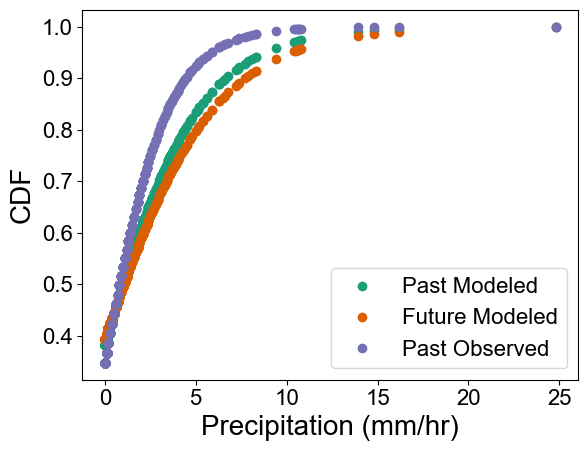

In [ ]:
# Plot CDFs ==================================================================================
# Select data to be plotted
x1 = projected_by_intensity.pr[:]
y1 = projected_by_intensity.obs_CDF[:]

x2 = x1
y2 = projected_by_intensity.past_CDF[:]

x3 = x1
y3 = projected_by_intensity.future_CDF[:]

# Change plot labels and axes
# plt.xticks([])    
# plt.xlim([-1.2, 82])
# plt.ylim([0.18, 1.02])
plt.xlabel("Precipitation (mm/hr)", fontsize = 20)
plt.ylabel("CDF", fontsize = 20)

# Construct plot
plt.plot(x2, y2, color = color0, marker='o', linestyle='', label='Past Modeled')
plt.plot(x3, y3, color = color1, marker='o', linestyle='', label='Future Modeled')
plt.plot(x1, y1, color = color2, marker='o', linestyle='', label='Past Observed')
plt.legend(loc = 'lower right')

plt.show

[]

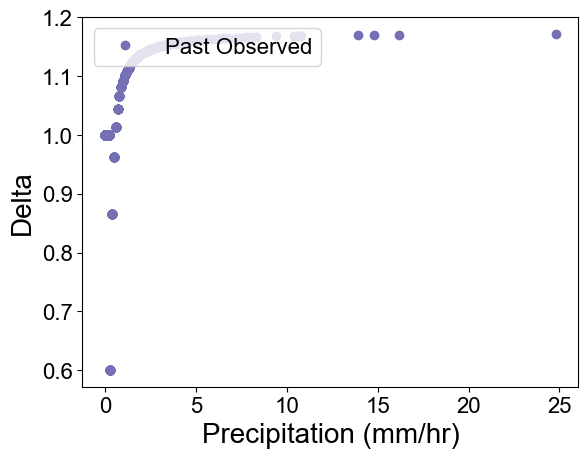

In [48]:
# Plot delta values for each precipitation intensity
# Select data to be plotted
x1 = y1 = 0
x1 = projected_by_intensity.pr[:]
y1 = projected_by_intensity.delta[:]

# Change plot labels and axes
# plt.xlim([-1.2, 84])
# plt.ylim([-0.1, 1.3])
plt.xlabel("Precipitation (mm/hr)", fontsize = 20)
plt.ylabel("Delta", fontsize = 20)

# Construct plot
plt.plot(x1, y1, color = color2, marker='o', linestyle='', label='Past Observed')
plt.legend(loc = 'upper left')

plt.plot()


<function matplotlib.pyplot.show(close=None, block=None)>

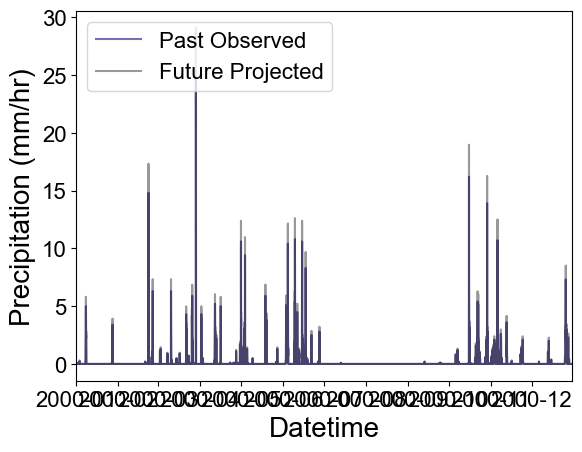

In [45]:
# Plot observed time series vs future projected time series
# Select data to be plotted
x1 = projected_by_intensity.datetime[:]
y1 = projected_by_intensity.pr[:]

x2 = x1
y2 = projected_by_intensity.projected_pr[:]

# Change plot labels and axes
plt.ylabel("Precipitation (mm/hr)", fontsize = 20)
plt.xlabel("Datetime", fontsize = 20)
plt.xlim([datetime.date(2000, 1, 1), datetime.date(2000, 12, 31)])
# plt.ylim([0, 50])

# Construct plot
plt.plot(x1, y1, color = color2, label='Past Observed', alpha = 1)
plt.plot(x2, y2, color = 'black', label='Future Projected', alpha = .4)

plt.legend(loc = 'upper left')


plt.show